In [20]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import math
import json
import datetime
from pandas.io.json import json_normalize
matplotlib.rc('font',family='AppleGothic')

In [21]:
json_file = open("1_20151101_heart.json", 'r')
json_data = json_file.read()
json_file.close()
heart_json = json.loads(json_data)

In [22]:
json_file = open("1_20151101_steps.json", 'r')
json_data = json_file.read()
json_file.close()
step_json = json.loads(json_data)

In [23]:
json_file = open("1_20151101_sleep.json", 'r')
json_data = json_file.read()
json_file.close()
sleep_json = json.loads(json_data)

## 그래프를 통해 심장박동 수와 걸음 수와 유사한 그래프 분포를 가지고 있음을 알 수 있다.

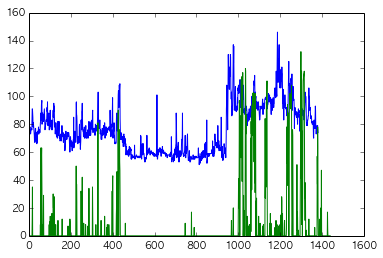

In [24]:
# 심장 박동 수와 걸을 걸이가 상관관계가 있는지 그래프를 통해 분석한다.
# 두 요소가 상관관계가 있음을 알 수 있다.
heart_json_df = json_normalize(heart_json[ u'activities-heart-intraday'][u'dataset'])
step_json_df = json_normalize(step_json[u'activities-steps-intraday'][u'dataset'])
step_json_df = step_json_df.rename(columns = {u'value':u'steps'})
heart_json_df = heart_json_df.rename(columns = {u'value': u'heart_beat'})
plt.plot(heart_json_df.index.tolist(), heart_json_df[u'heart_beat'].tolist())
plt.plot(step_json_df.index.tolist(), step_json_df[u'steps'].tolist())

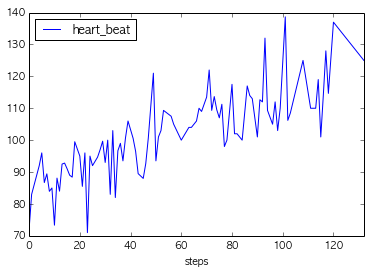

In [25]:
# 걸음 걸이 수에 해당하는 평균 심장박동 수를 구하면 선형 관계가 있음을 알 수 있다.
merge_data = step_json_df.merge(heart_json_df, left_on = u'time', right_on = u'time', how = 'outer')
step_per_heat = merge_data.groupby([u'steps']).mean()
step_per_heat.plot()

In [26]:
# 선형 회귀 모델을 만들 기 위해
# X축을 걸음 거리 수 Y축을 심장 박동 수로 구한다.
step_per_heat.to_csv('average_heart_beat_per_steps.csv')
dataset = pd.read_csv('average_heart_beat_per_steps.csv')
X = dataset[u'steps'].tolist()
Y = dataset[u'heart_beat'].tolist()

('Coefficients:', array([ 0.3500709]))
RMSE: 10.07
Variance score: -0.09


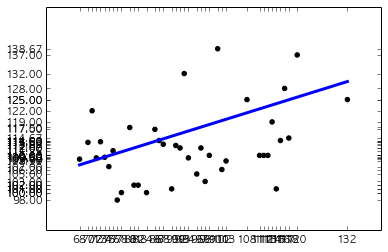

In [27]:
# 훈련 데이터셋과 검증 데이터셋을 나누어서 학습을 시킨다.
# 랜덤으로 섞어야 하나 이번 과제에서는 앞 부분과 뒷 부분으로 나누어서 쓴다.
# 실제로 결과가 앞 부분 데이터에 오버피팅 되는 것을 볼 수 있다. 그럭저럭 맞으므로 쓴다..
from sklearn import datasets
from sklearn.linear_model import LinearRegression
train_x, test_x = np.array(X[:-40]), np.array(X[-40:])
train_y, test_y = np.array(Y[:-40]), np.array(Y[-40:])
train_x = train_x.reshape(-1, 1)
test_x =test_x.reshape(-1, 1)
regr = LinearRegression()
regr.fit(train_x, train_y)
print('Coefficients:', regr.coef_)
print("RMSE: %.2f" % np.sqrt(np.mean((regr.predict(test_x) - test_y) ** 2)))
print('Variance score: %.2f' % regr.score(test_x, test_y))
plt.scatter(test_x, test_y,  color='black')
plt.plot(test_x, regr.predict(test_x), color='blue', linewidth=3)
plt.xticks(test_x)
plt.yticks(test_y)
plt.show()

## 1. 수면로그 시간기록 이 30초 단위로 측정하므로 다른 데이터와 결합하기 위해서 시간을 00초를 기준으로 조절한다.
## 2. 수면 기록의 경우 NaN이면 비수면 1 이상이면 수면 상태로 설정한다. (0/1)

In [28]:
sleep_json_df = json_normalize(sleep_json[u'sleep'][0][u'minuteData'])
sleep_json_df = sleep_json_df.rename(columns = {u'value':u'status'})
sleep_json_df = sleep_json_df.rename(columns = {u'dateTime':u'time'})
for t in range(len(sleep_json_df[u'time'])):
    sleep_json_df[u'time'][t] = sleep_json_df[u'time'][t].split(':')[0] + ':' + sleep_json_df[u'time'][t].split(':')[1] + u':00'

In [46]:
multiple_merge_data = merge_data.merge(sleep_json_df, left_on = u'time', right_on = u'time', how = 'outer')
multiple_merge_data.to_csv('multiple_data.csv')
step_json_df.to_csv('steps.csv')
sleep_json_df.to_csv('sleeps.csv')
heart_json_df.to_csv('hearts.csv')
for t in range(len(multiple_merge_data[u'status'])):
    if pd.isnull(multiple_merge_data[u'status'][t]):
        multiple_merge_data[u'status'][t] = 0
    else:
        multiple_merge_data[u'status'][t] = 1

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
average_heat_pet_steps_with_status =  multiple_merge_data.groupby([u'steps', u'status']).mean()

In [48]:
average_heat_pet_steps_with_status.to_csv('average_heat_pet_steps_with_status.csv')

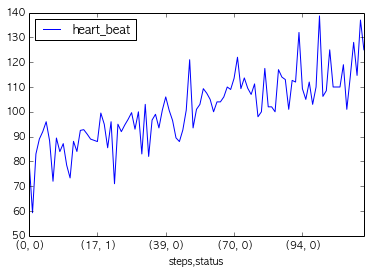

In [49]:
average_heat_pet_steps_with_status.plot()

## 심장 박동 수와 움직인 걸음 수는 비례관계
## 심장 박동 수와 수면 상태 수는 반비례 관계임을 이용하여
## 선형회귀법을 이용하여 심장박동수를 예상해본다.
## Polynomial Linear Regression을 이용하면 더 정확한 데이터를 예측가능 할 것으로 예상
## Steps가 0 인 경우 심장박동수를 이용하여 SVM으로 Hyperplane을 이용하면 
## Status가 0인 경우 사용자가 졸고 있는지 여부도 확인가능할 거라고 조심스럽게 추정..

In [50]:
multiple_dataset = pd.read_csv('average_heat_pet_steps_with_status.csv')
X1 = multiple_dataset[u'steps'].tolist()
X2 = multiple_dataset[u'status'].tolist()
Y = multiple_dataset[u'heart_beat'].tolist()
X = zip(X1, X2)

## 상관계수를 통해 걸음 걸이가 증가하면 심장 박동 수가 증가하고
## Status가 증가하면 심장박동 수가 감소 함을 알 수있다.
## Status -> 0: 비수면 1: 수면 상태로 선택함

(2, 99)
('Coefficients:', array([  0.28702823, -13.57812096]))
RMSE: 7.86
Variance score: 0.68


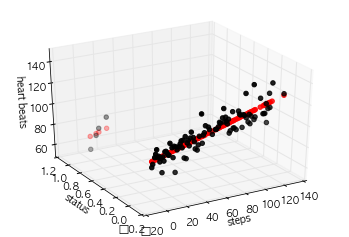

In [51]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import interactive
interactive(True)
train_x = np.array(X)
train_y = np.array(Y).T
print train_x.T.shape
regr = LinearRegression()
regr.fit(train_x, train_y)
print('Coefficients:', regr.coef_)
print("RMSE: %.2f" % np.sqrt(np.mean((regr.predict(train_x) - train_y) ** 2)))
print('Variance score: %.2f' % regr.score(train_x, train_y))
threed_graph = plt.figure().gca(projection='3d')
threed_graph.scatter(train_x.T[0].tolist(), train_x.T[1].tolist(),  regr.predict(train_x).tolist(),  color='red')
threed_graph.scatter(train_x.T[0].tolist(),  train_x.T[1].tolist(), train_y.tolist(),  color='black')
threed_graph.set_xlabel('steps')
threed_graph.set_ylabel('status')
threed_graph.set_zlabel('heart beats')
threed_graph.view_init(30, 240)
plt.draw()

In [53]:
multiple_merge_data.groupby([u'status']).count()

,time,steps,heart_beat
status,,,
0,936,936,936
1,504,504,446
